# Time Series Forecasting – ML Approach Part 2

In [2]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
from statsmodels.tools.sm_exceptions import ValueWarning
warnings.simplefilter('ignore', ValueWarning)

### Hidden Markov Models (HMM)

In [5]:
from hmmlearn import hmm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [6]:
url1 = ('https://raw.githubusercontent.com/OrangeAVA/Mastering-Time-Series-Analysis-and-Forecasting-with-Python/refs/heads/main/ProductSalesData.csv')

df = pd.read_csv(url1)

df.drop(columns = ['Unnamed: 0'], inplace = True)

df.head()

,Date,Stock Level,Discount,Promotion,Units Sold
0,2010-01-01,2381.0,8.506768,Yes,59.0
1,2010-01-02,3252.0,9.283937,No,203.0
2,2010-01-03,2883.0,9.548446,No,33.0
3,2010-01-04,3586.0,9.660054,Yes,117.0
4,2010-01-05,3578.0,9.086065,No,71.0


In [7]:
units_sold = df['Units Sold'].values
units_sold

array([ 59., 203.,  33., ..., 231., 122., 141.])

In [8]:
# Split in train set and test set
train, test = train_test_split(units_sold, test_size=0.2, shuffle=False)

In [9]:
# Initializes a Gaussian Hidden Markov Model
model = hmm.GaussianHMM(n_components=4,          # 4 hidden states
                        covariance_type="diag",  # diagonal covariance
                        n_iter=100)              # 100 iterations

# Fits the model to the training data, reshaped to a 2D array (required by HMM)
model.fit(train.reshape(-1, 1))

GaussianHMM(n_components=4, n_iter=100)

In [10]:
predicted = []  # Initialize an empty list to store the predicted values

# Iterate over each test data point
for i in range(len(test)):  

    # Use the last value of 'train' for the first prediction, otherwise use the last predicted value
    previous = np.array(train[-1]).reshape(1, -1) if i == 0 else np.array(predicted[-1]).reshape(1, -1)  
    
    next_step = model.predict(previous)  # Predict the next step using the HMM model
    
    predicted.append(next_step[0])       # Append the predicted state to the list

In [11]:
mse = mean_squared_error(test, predicted)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test, predicted)

print('     Mean Squared Error:', mse)
print('Root Mean Squared Error:', rmse)
print('    Mean Absolute Error:', mae)

     Mean Squared Error: 80324.56788899901
Root Mean Squared Error: 283.4158920896974
    Mean Absolute Error: 232.7938553022795


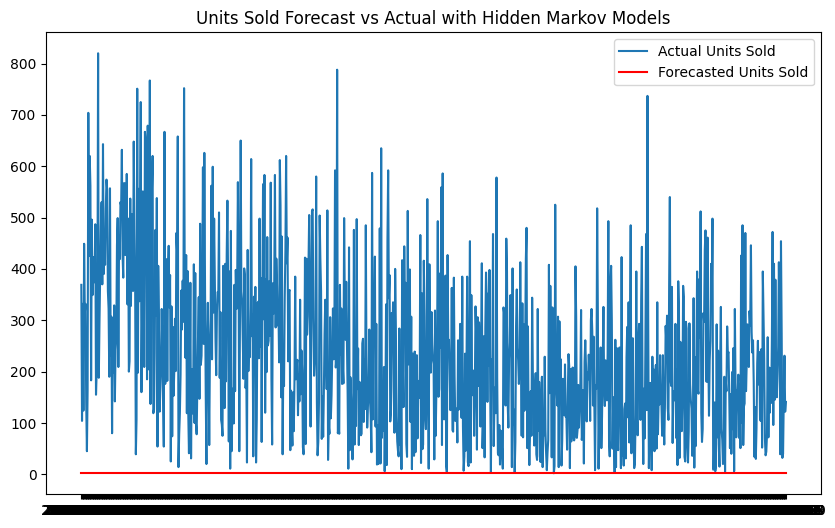

In [12]:
plt.figure(figsize=(10,6))
plt.plot(df.iloc[-test.shape[0]:]['Date'], test, label='Actual Units Sold')
plt.plot(df.iloc[-test.shape[0]:]['Date'], predicted, label='Forecasted Units Sold', color='red')
plt.title('Units Sold Forecast vs Actual with Hidden Markov Models')
plt.legend()
plt.show()

In [13]:
predicted[0:10]

[3, 3, 3, 3, 3, 3, 3, 3, 3, 3]

In [14]:
test[0:10]

array([369., 104., 332., 124., 449., 314., 332., 138.,  45., 164.])

The data may require transformations before applying the model to it.

### Gaussian Process

In [17]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [18]:
data = pd.read_csv(url1)

units_sold = data['Units Sold'].values

In [19]:
time_indices = np.arange(len(units_sold)).reshape(-1, 1)

In [20]:
X_train, X_test, y_train, y_test = train_test_split(time_indices, units_sold, test_size=0.2, shuffle = False)

In [21]:
# Defines a kernel combining a constant term (C) and a radial basis function (RBF) with specified bounds
kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))  

# Initializes a Gaussian Process Regressor with the defined kernel and 10 restarts for optimization
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)  

In [22]:
gp.fit(X_train, y_train)

GaussianProcessRegressor(kernel=1**2 * RBF(length_scale=10),
                         n_restarts_optimizer=10)

In [23]:
y_pred, sigma = gp.predict(X_test, return_std=True)

In [24]:
y_pred

array([-6.21510445e+01, -4.09202033e+00, -3.46637344e-02, ...,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00])

In [25]:
sigma

array([28.833268  , 31.61394078, 31.62277599, ..., 31.6227766 ,
       31.6227766 , 31.6227766 ])

In [26]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)

print('     Mean Squared Error:', mse)
print('Root Mean Squared Error:', rmse)
print('    Mean Absolute Error:', mae)

     Mean Squared Error: 81780.48873787059
Root Mean Squared Error: 285.9728811231418
    Mean Absolute Error: 235.85755973342904


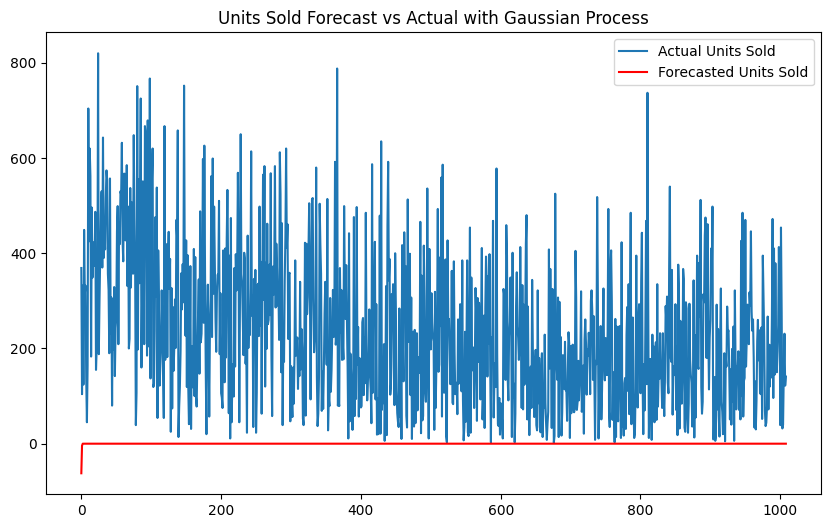

In [27]:
plt.figure(figsize=(10,6))
plt.plot(y_test, label='Actual Units Sold')
plt.plot(y_pred, label='Forecasted Units Sold', color='red')
plt.title('Units Sold Forecast vs Actual with Gaussian Process')
plt.legend()
plt.show()

In [28]:
predicted[0:10]

[3, 3, 3, 3, 3, 3, 3, 3, 3, 3]

In [29]:
test[0:10]

array([369., 104., 332., 124., 449., 314., 332., 138.,  45., 164.])

The Forecasted Units Sold is represented by a flat line
near the x-axis, suggesting that the Gaussian Process
Regressor predicted nearly the same value for the entire test
set. This flat line indicates that the model did not capture the
variability in the actual sales data, implying that the model
has not performed well in forecasting the future values of the
series.

This suggests that either the model is not suitable for
forecasting this data, or we might need to do more data
preprocessing and transformation to make this model fit the
data.

# Machine Learning based approach

In [32]:
def load_and_preprocess_data(file_name):
    df = pd.read_csv(file_name)
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)
    df['Lag_1'] = df['Units Sold'].shift(1)
    df.dropna(inplace=True)
    return df

def split_data(df):
    X = df[['Lag_1']]
    y = df['Units Sold']
    return train_test_split(X, y, test_size=0.2, shuffle=False)

def fit_and_predict(model, X_train, y_train, X_test):
    model.fit(X_train, y_train)
    return model.predict(X_test)

def evaluate_model(y_test, y_pred):
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    return mse, rmse, mae

def plot_results(y_test, y_pred, title):
    plt.figure(figsize=(15,6))
    plt.plot(y_test.index, y_test, label='Actual Units Sold')
    plt.plot(y_test.index, y_pred, label='Forecasted Units Sold', color='red')
    plt.title(title)
    plt.legend()
    plt.show()

#### Load and pre-process the data

In [34]:
df = load_and_preprocess_data(url1)

#### Split the data into train and test

In [36]:
X_train, X_test, y_train, y_test = split_data(df)

X_train.head(5)

,Lag_1
Date,
2010-01-02,59.0
2010-01-03,203.0
2010-01-04,33.0
2010-01-05,117.0
2010-01-06,71.0


## Support Vector Machine (SVM)

In [38]:
from sklearn.svm import SVR

svm_model = SVR()

y_pred_svm = fit_and_predict(svm_model, X_train, y_train, X_test)

mse_svm, rmse_svm, mae_svm = evaluate_model(y_test, y_pred_svm)

print('     Mean Squared Error:', mse_svm)
print('Root Mean Squared Error:', rmse_svm)
print('    Mean Absolute Error:', mae_svm)

     Mean Squared Error: 30717.93826290258
Root Mean Squared Error: 175.2653367409043
    Mean Absolute Error: 146.8309981075176


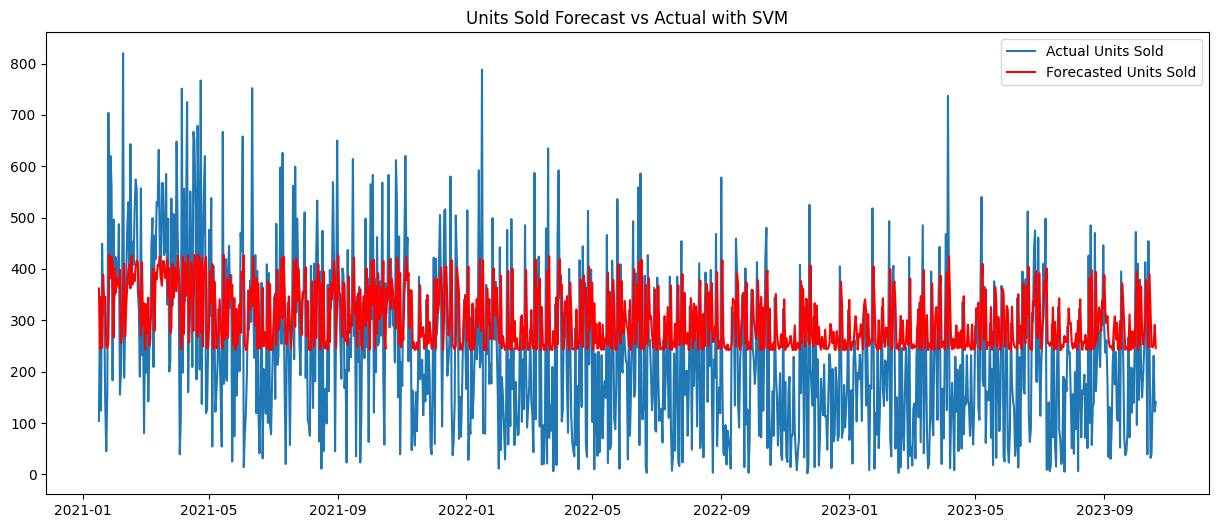

In [39]:
plot_results(y_test, y_pred_svm, 'Units Sold Forecast vs Actual with SVM')

## K-Nearest Neighbors (KNN)

In [41]:
from sklearn.neighbors import KNeighborsRegressor

knn_model = KNeighborsRegressor(n_neighbors=5)

y_pred_knn = fit_and_predict(knn_model, X_train, y_train, X_test)

mse_knn, rmse_knn, mae_knn = evaluate_model(y_test, y_pred_knn)

print('     Mean Squared Error:', mse_knn)
print('Root Mean Squared Error:', rmse_knn)
print('    Mean Absolute Error:', mae_knn)

     Mean Squared Error: 36146.26813492064
Root Mean Squared Error: 190.12171926142642
    Mean Absolute Error: 156.84345238095239


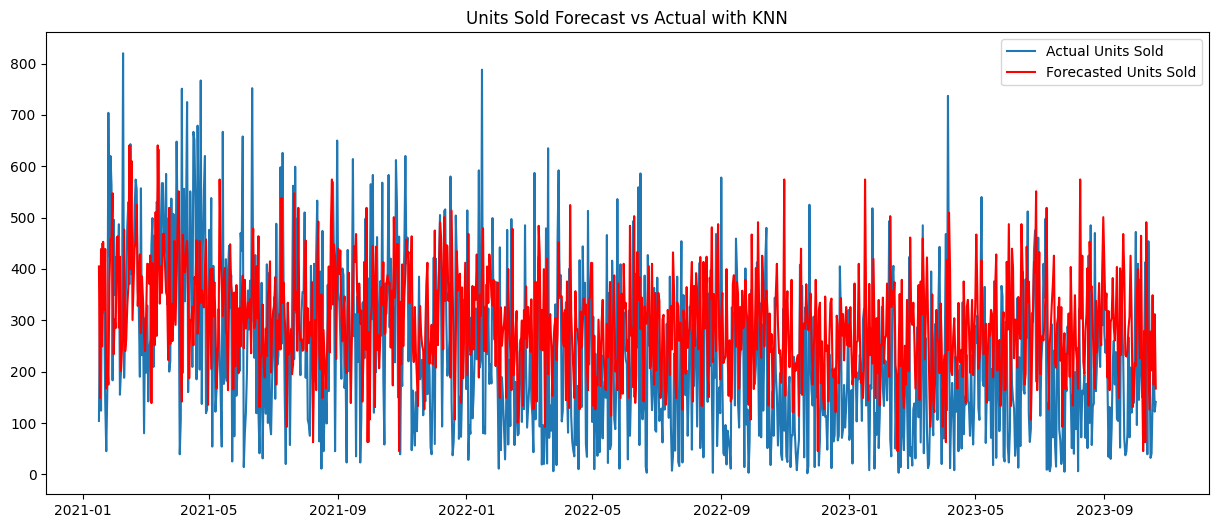

In [42]:
plot_results(y_test, y_pred_knn, 'Units Sold Forecast vs Actual with KNN')

## Random Forest

In [44]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=100)

y_pred_rf = fit_and_predict(rf_model, X_train, y_train, X_test)

mse_rf, rmse_rf, mae_rf = evaluate_model(y_test, y_pred_rf)

print('     Mean Squared Error:', mse_rf)
print('Root Mean Squared Error:', rmse_rf)
print('    Mean Absolute Error:', mae_rf)

     Mean Squared Error: 37315.01384857211
Root Mean Squared Error: 193.17094462825435
    Mean Absolute Error: 158.40748719452668


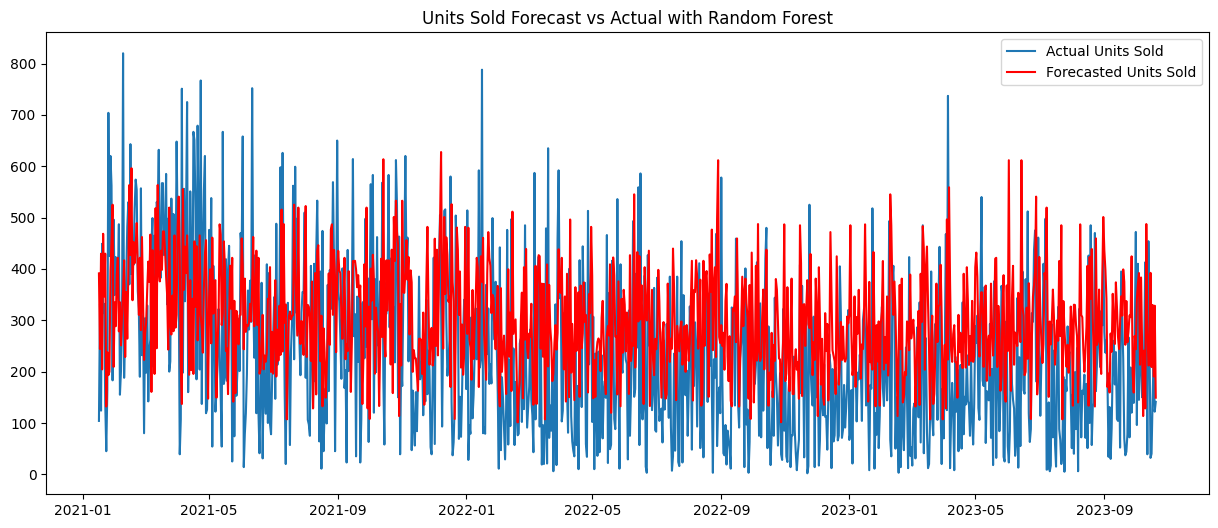

In [45]:
plot_results(y_test, y_pred_rf, 'Units Sold Forecast vs Actual with Random Forest')

## Gradient Boosting

In [47]:
from sklearn.ensemble import GradientBoostingRegressor

gb_model = GradientBoostingRegressor(n_estimators=100)

y_pred_gb = fit_and_predict(gb_model, X_train, y_train, X_test)

mse_gb, rmse_gb, mae_gb = evaluate_model(y_test, y_pred_gb)

print('     Mean Squared Error:', mse_gb)
print('Root Mean Squared Error:', rmse_gb)
print('    Mean Absolute Error:', mae_gb)

     Mean Squared Error: 31976.61504444344
Root Mean Squared Error: 178.82006331629412
    Mean Absolute Error: 149.4313760353675


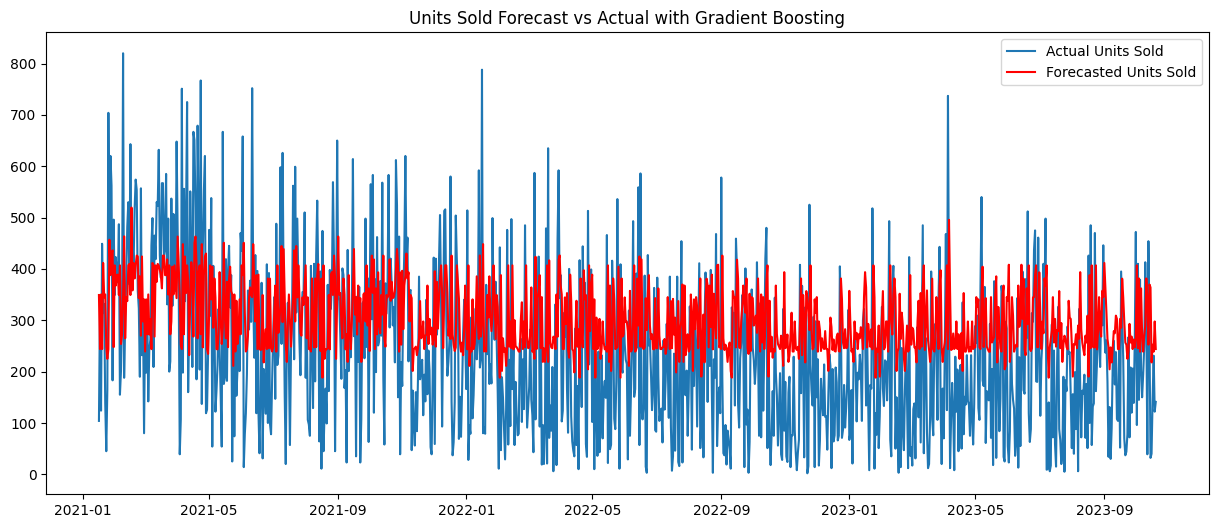

In [48]:
plot_results(y_test, y_pred_gb, 'Units Sold Forecast vs Actual with Gradient Boosting')